# Libraries update

In [1]:
%pip install --upgrade pandas
%pip install yfinance
%pip install ta==0.10.2
%pip install scikit-learn
%pip install tensorflow
%pip install flask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 65.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=afa3019317405e205b83e87105a619cf6cee4eb685b05198537bc0bdd576c4cb
  Stored in directo

# Importing libraries

In [2]:
import math
import numpy as np
import pandas as pd
import random
from flask import Flask, jsonify
import matplotlib.pyplot as plt
import ta
import yfinance as yf
import plotly.graph_objects as go
from enum import Enum
from ta.utils import dropna
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from pandas_datareader import data as pdr
yf.pdr_override()
app = Flask(__name__)

# Input data

In [3]:
# Download actual stock prices from Yahoo Finance
ticker = "AAPL"
start_date = "2018-04-01"
end_date = "2023-04-01"

# Recurrent Neural Network (RNN)

In [4]:
# Values for the Recurrent Neural Network (RNN)
stock_dataRNN = yf.download(ticker, start=start_date, end=end_date)

# Obtain the MACD technical indicator via the Technical Analysis Library.
macd = ta.trend.MACD(close=stock_dataRNN['Close'])
stock_dataRNN['MACD'] = macd.macd_diff()

# Obtain the RSI technical indicator via the Technical Analysis Library.
stock_dataRNN['RSI'] = ta.momentum.RSIIndicator(stock_dataRNN['Close']).rsi()

# Create a new dataframe with only the 'Close' column data of the stock_dataRNN
data = stock_dataRNN.filter(['Close'])

# Convert the dataframe to a numpy array
dataset = data.values

# Get the number of rows to train the model and determined that the training data set contains about 80% of the data.
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

# Scale all data to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create scaled training dataset
train_data = scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train datasets
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

# Convert x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data into the format accepted by LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
#model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

# Test data set
test_data = scaled_data[training_data_len - 60: , : ]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

# Convert x_test to a numpy arrays 
x_test = np.array(x_test)

# Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

# Getting the models predicted price values
predictions = model.predict(x_test, verbose=0)
predictions = scaler.inverse_transform(predictions)

# Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))

# Predict actual price of the next day:
next_day = data.tail(60).values
next_day_scaled = scaler.transform(next_day)
next_day_reshaped = np.reshape(next_day_scaled, (1, next_day.shape[0], 1))
next_day_prediction = model.predict(next_day_reshaped, verbose=0)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
#print("Next day prediction:", next_day_prediction[0][0])

[*********************100%***********************]  1 of 1 completed


# Genetic Algorithm (GA)

In [5]:
# Values for the Genetic Algorithm (GA)
stock_dataGA = yf.download(ticker, start=start_date, end=end_date)["Adj Close"].values

# Define the chromosome
chromosome_size = 2
min_weight = -1
max_weight = 1
chromosome = np.random.uniform(low=min_weight, high=max_weight, size=chromosome_size)

# Define the fitness function
def fitness_function(weights, stock_dataGA):
    predicted_prices = predict_prices(weights, stock_dataGA)
    mse = np.mean((predicted_prices - stock_dataGA)**2)
    return -mse  # Negative because we want to maximize fitness

# Define the function to predict future stock prices
def predict_prices(weights, stock_dataGA):
    # Use a simple linear model to predict future stock prices
    num_prices = len(stock_dataGA)
    future_prices = np.zeros(num_prices)
    for i in range(1, num_prices):
        future_prices[i] = stock_dataGA[i-1] * weights[0] + weights[1]
    return future_prices

# Initialize the population
population_size = 50
population = [np.random.uniform(low=min_weight, high=max_weight, size=chromosome_size) for _ in range(population_size)]

# Set termination criteria
max_generations = 100
target_fitness = 1000

# Keep track of best fitness and chromosome
best_fitness = -float('inf')
best_chromosome = None
fitness_history = []

# Run genetic algorithm
for generation in range(max_generations):
    # Evaluate the fitness
    fitness_scores = [fitness_function(chromosome, stock_dataGA) for chromosome in population]

    # Selection
    tournament_size = 5
    selected_indices = []
    for _ in range(population_size):
        tournament_indices = np.random.choice(range(population_size), size=tournament_size, replace=False)
        tournament_fitness_scores = [fitness_scores[i] for i in tournament_indices]
        winner_index = tournament_indices[np.argmax(tournament_fitness_scores)]
        selected_indices.append(winner_index)
    selected_population = [population[i] for i in selected_indices]

    # Crossover
    crossover_probability = 0.8
    offspring = []
    for i in range(0, population_size, 2):
        parent1 = selected_population[i]
        parent2 = selected_population[i+1]
        if random.random() < crossover_probability:
            crossover_point = random.randint(0, chromosome_size-1)
            child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        else:
            child1 = parent1
            child2 = parent2
        offspring.append(child1)
        offspring.append(child2)

    # Mutation
    mutation_probability = 0.1
    for i in range(population_size):
        chromosome = offspring[i]
        for j in range(chromosome_size):
            if random.random() < mutation_probability:
                chromosome[j] = np.random.uniform(low=min_weight, high=max_weight)
        offspring[i] = chromosome

    # Create the next generation
    population = offspring

    # Update best fitness and chromosome
    best_index = np.argmax(fitness_scores)
    if fitness_scores[best_index] > best_fitness:
      best_fitness = fitness_scores[best_index]
      best_chromosome = population[best_index]
      
    # Print progress
    #print(f"Generation: {generation+1} - Best Fitness: {-best_fitness:.2f}")

# Predict future stock price
future_price = predict_prices(best_chromosome, stock_dataGA)[-1]

# Buy, Sell, or Hold recommendation
class Recommendation(Enum):
    BUY = "Buy"
    SELL = "Sell"
    HOLD = "Hold"

def get_recommendation(best_fitness):
    if best_fitness >= 0.5:
        return Recommendation.SELL
    elif best_fitness <= -0.5:
        return Recommendation.BUY
    else:
        return Recommendation.HOLD

recommendation = get_recommendation(-best_fitness)
#print("Next day prediction:", future_price)
#print("Recommendation:", recommendation.value)

[*********************100%***********************]  1 of 1 completed


# Free Plan Output

# Historical Series: Closing Price

In [10]:
@app.route('/api/stock_data')
def get_stock_data():
    # generate the plot
    plt.figure(figsize=(30,15))
    plt.title('Close Price History')
    plt.plot(stock_dataRNN['Close'])
    plt.xlabel('Date',fontsize=10)
    plt.ylabel('Close Price USD ($)',fontsize=18)
    
    # convert the plot to base64-encoded image data
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_data = base64.b64encode(buffer.read()).decode('ascii')
    
    # return the image data as JSON
    return jsonify({'image_data': image_data})

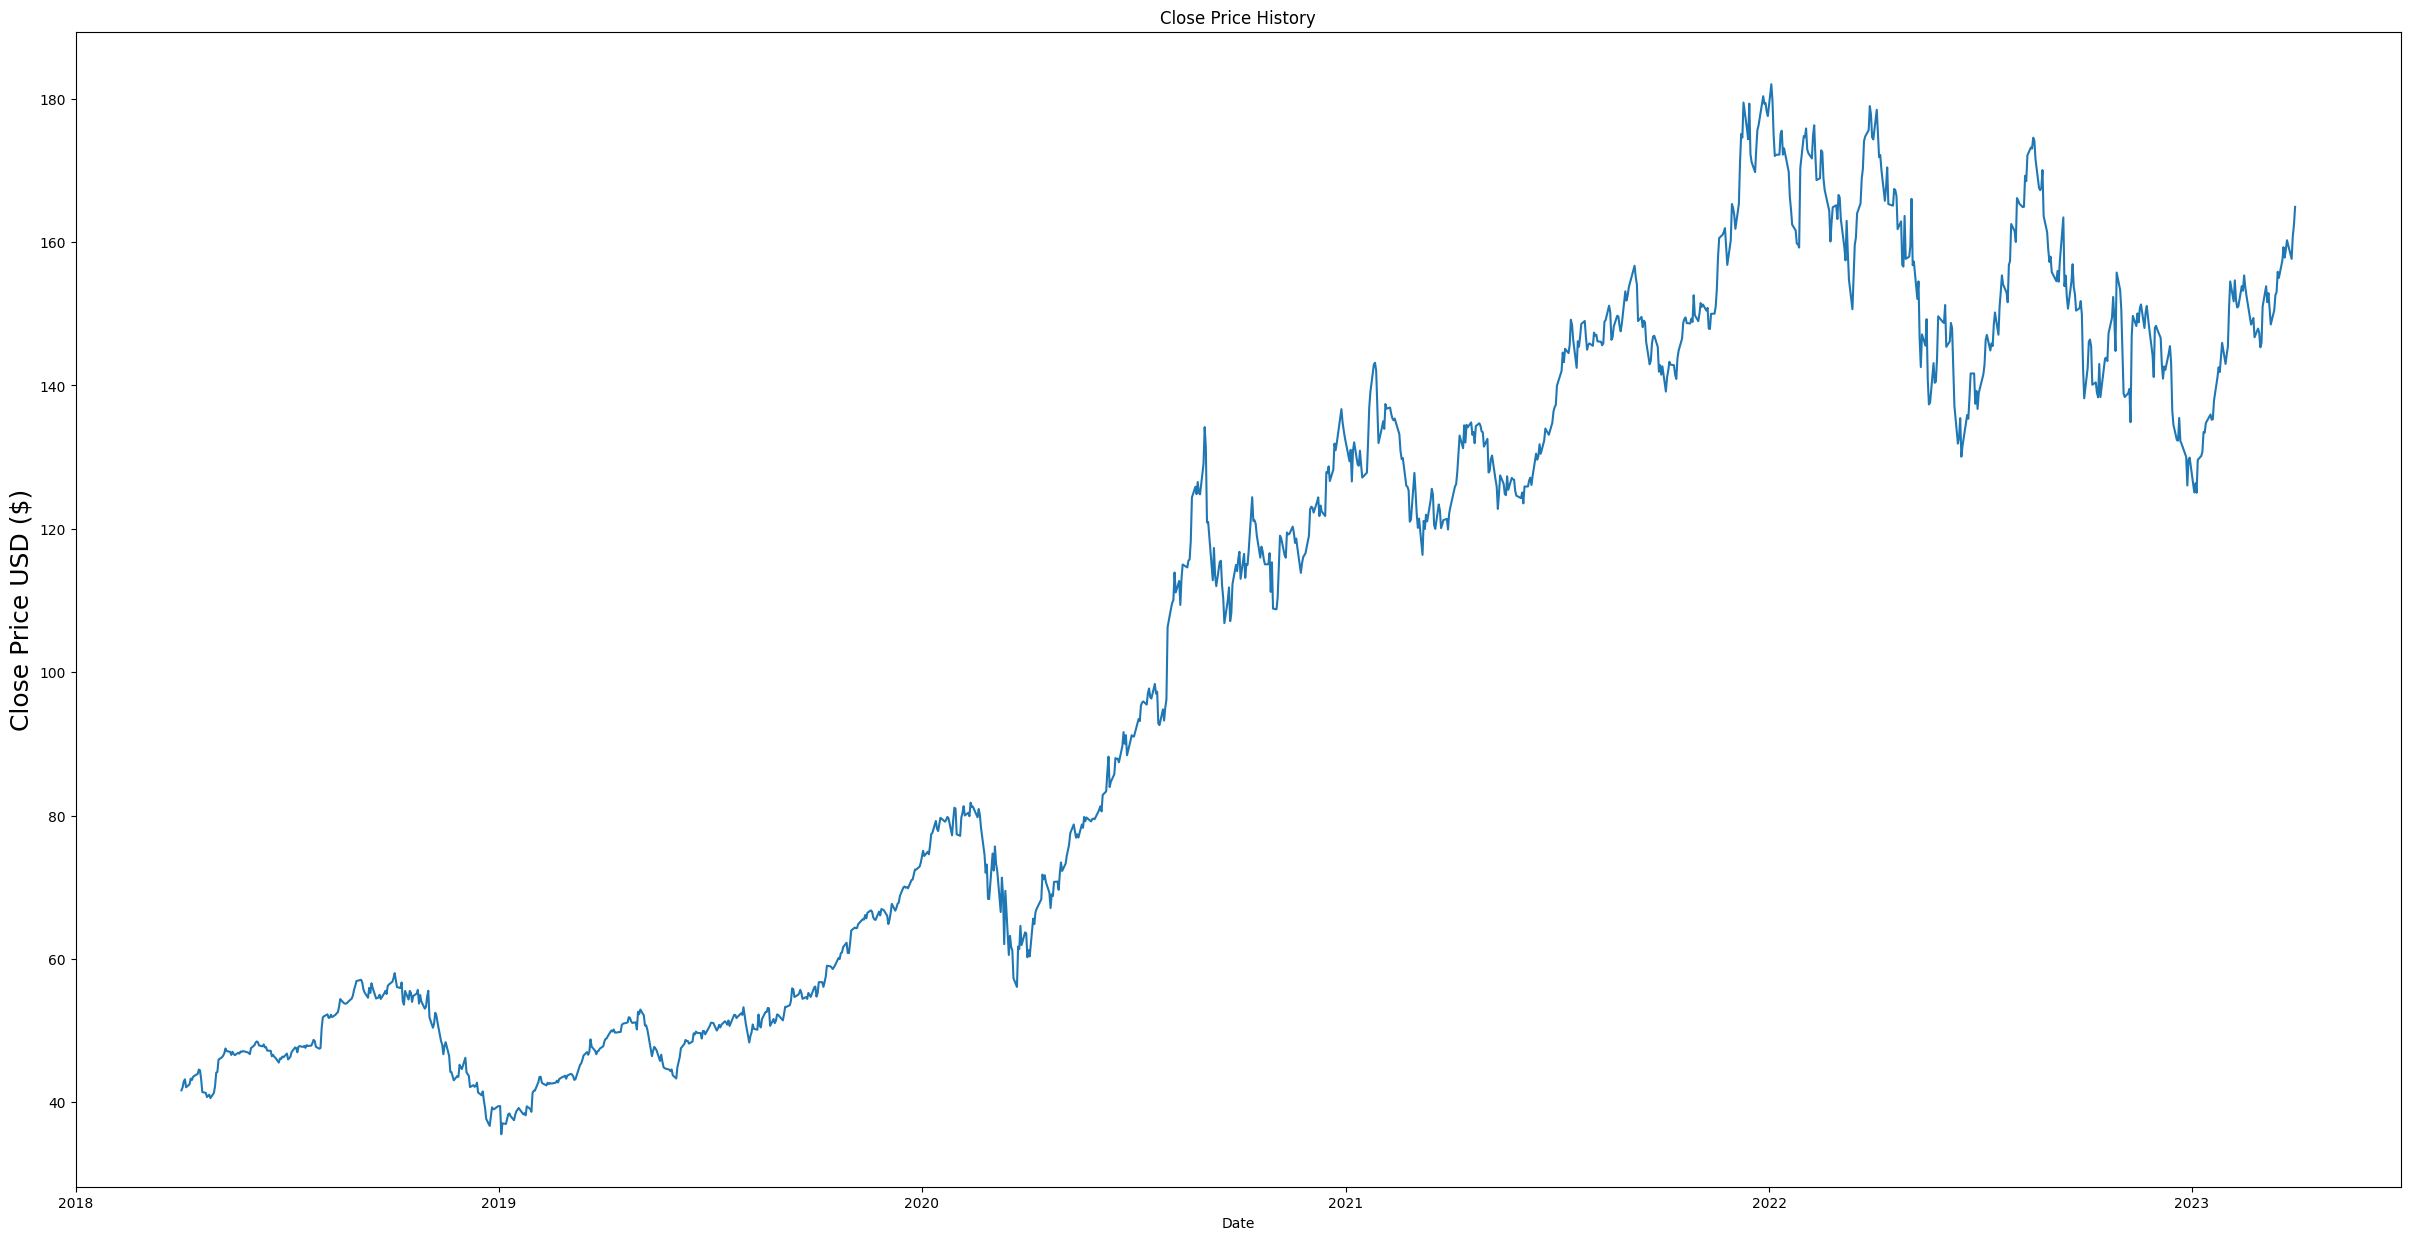

In [11]:
# Plot historical closing price.
plt.figure(figsize=(30,15))
plt.title('Close Price History')
plt.plot(stock_dataRNN['Close'])
plt.xlabel('Date',fontsize=10)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()


# Basic Plan Output

# Historical Series: Candlestick Chart

In [12]:
# Plot historical series via Candlestick chart.
candlestick = go.Figure(data=go.Ohlc(
    x=stock_dataRNN.index,
    open=stock_dataRNN['Open'],
    high=stock_dataRNN['High'],
    low=stock_dataRNN['Low'],
    close=stock_dataRNN['Close']
))
candlestick.update_layout(xaxis_rangeslider_visible=False)
candlestick.update_layout(title_text='Candlestick', title_x=0.5)
candlestick.update_layout(yaxis_title='Price')
candlestick.update_layout(xaxis_title='Period')
candlestick.show()

# Historical Series: MACD Technical Indicator Chart

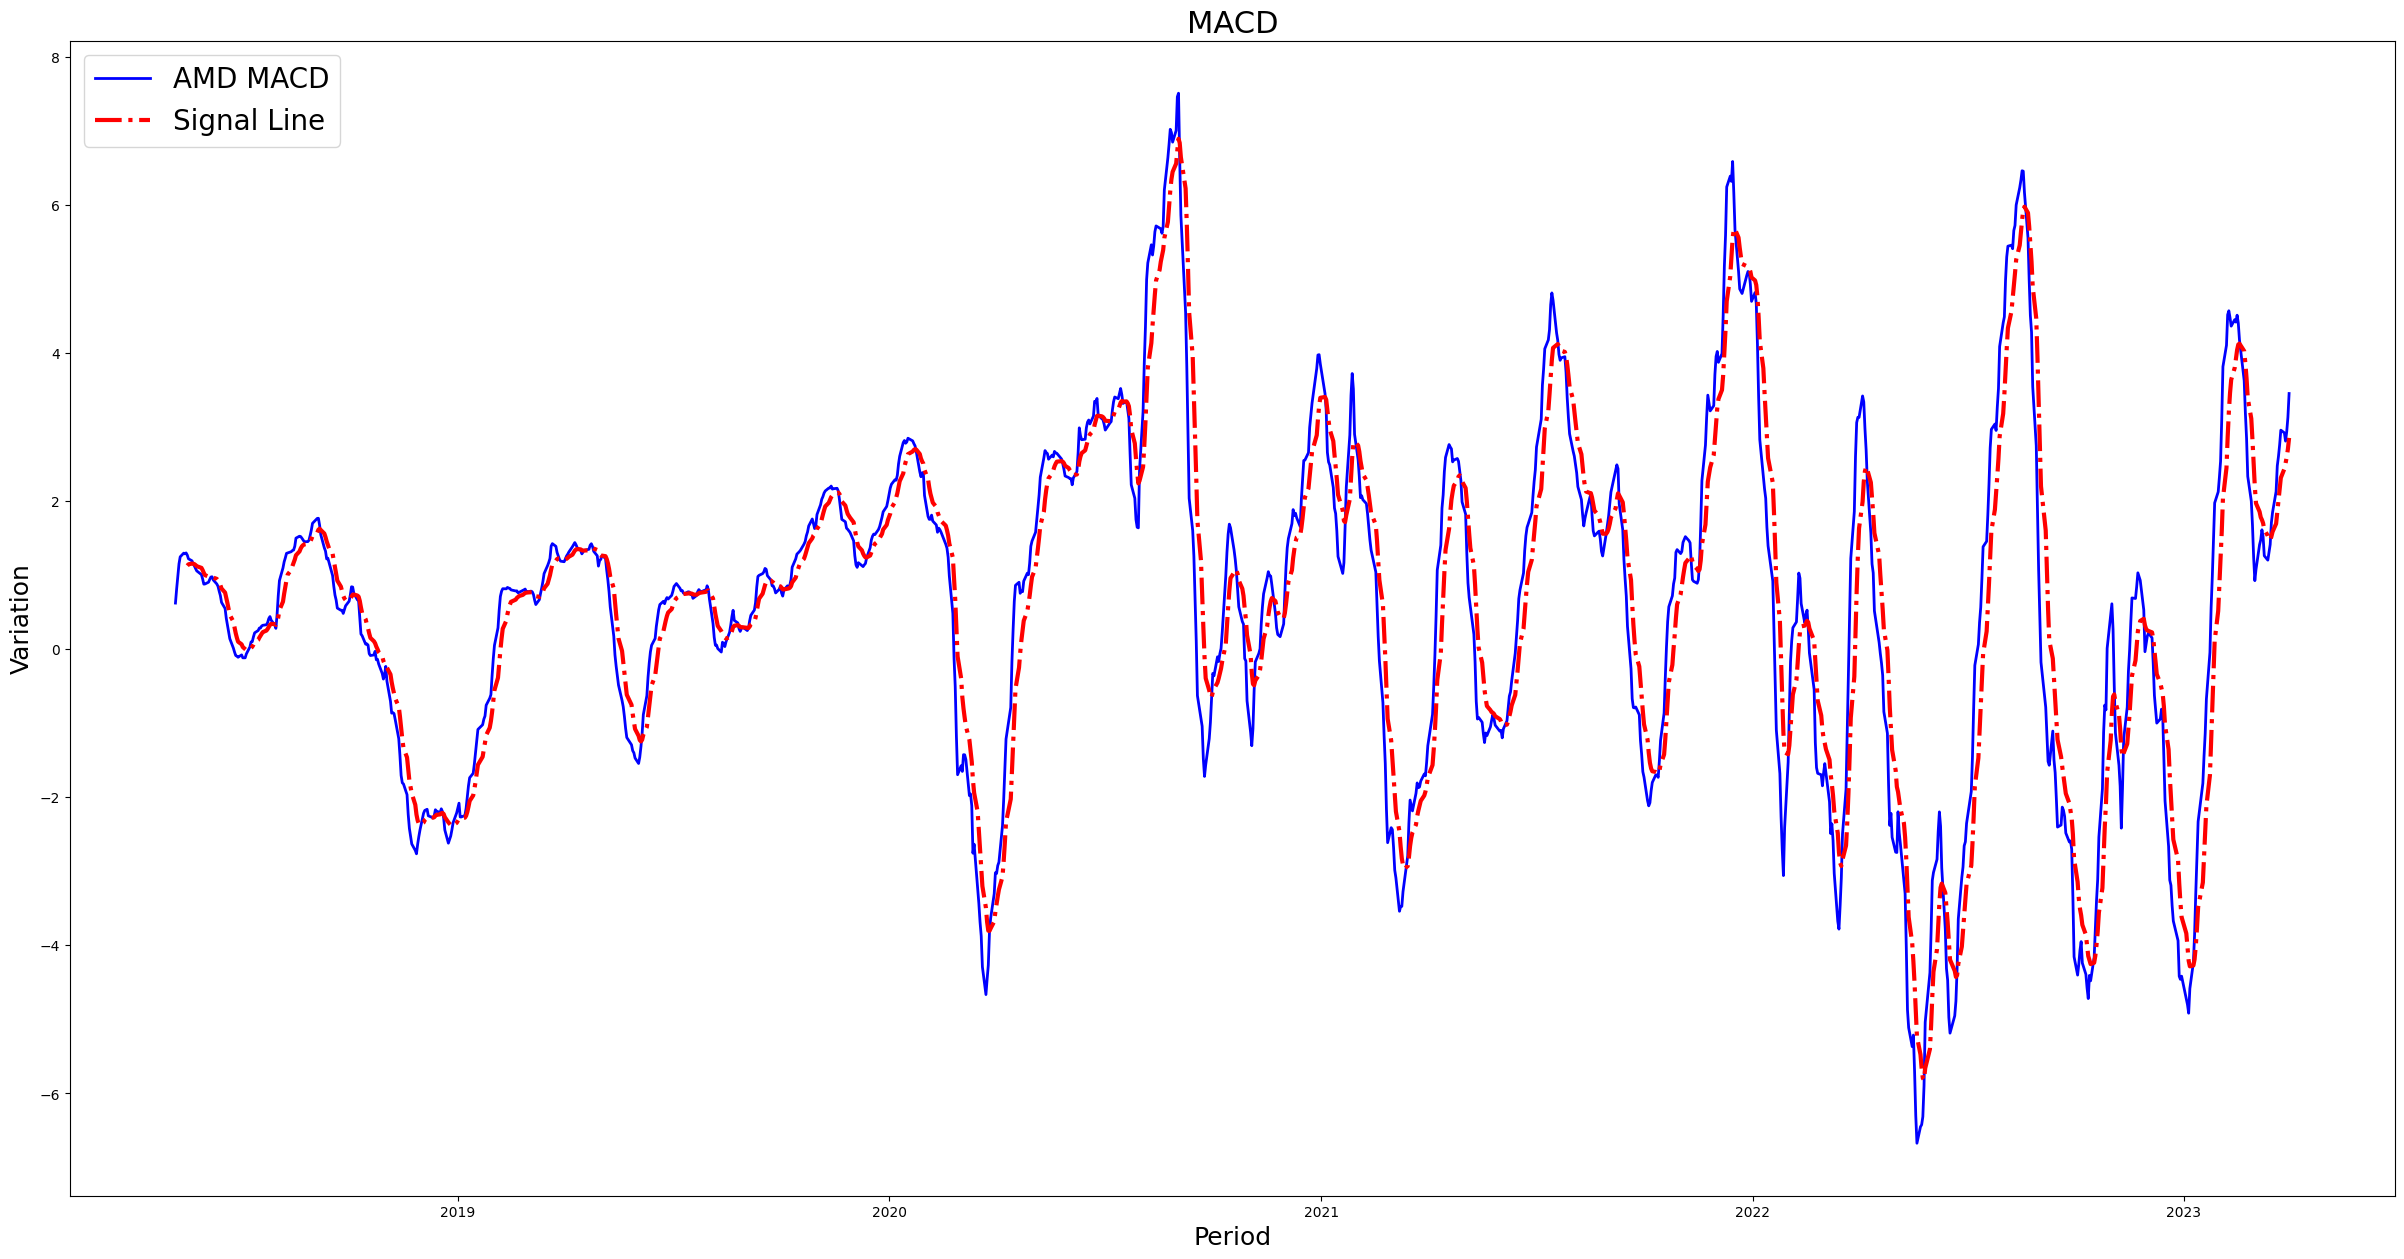

In [13]:
# Display data via MACD technical indicator chart.
plt.figure(figsize=(30,15))
plt.title("MACD",fontsize=22)
plt.xlabel('Period',fontsize=18)
plt.ylabel('Variation',fontsize=18)
plt.plot(macd.macd(), label='AMD MACD', color='blue',linewidth = 2)
plt.plot(macd.macd_signal(), label='Signal Line', color='red', linestyle = 'dashdot', linewidth = 3)
plt.legend(loc='upper left', fontsize=(20))

# Historical Series: Display data via RSI technical indicator chart


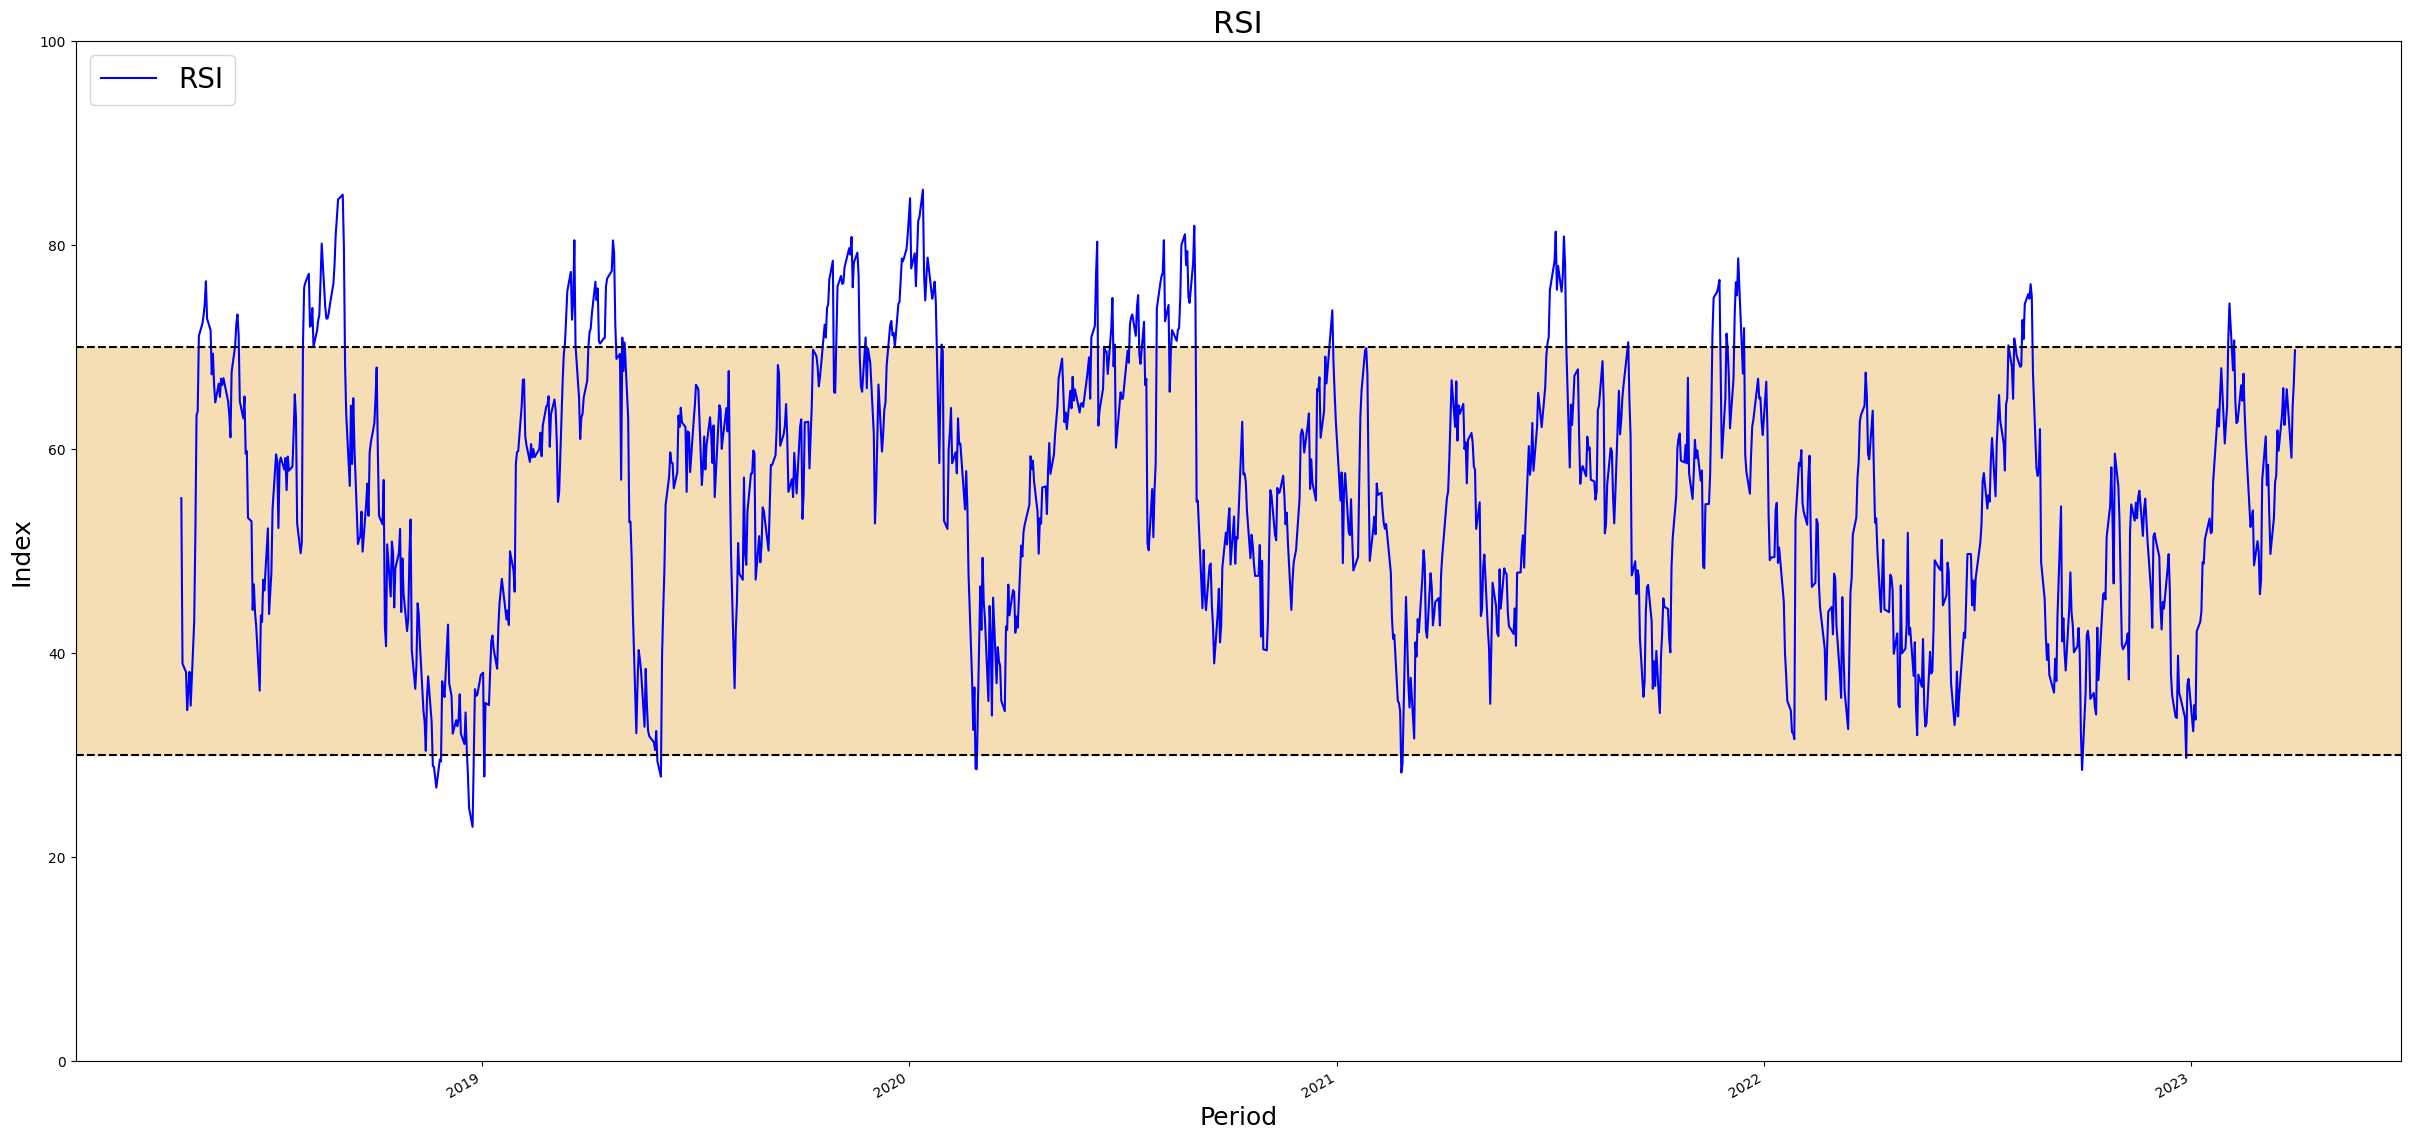

In [14]:
plt.figure(figsize=(30,15))
plt.title("RSI", fontsize=22)
stock_dataRNN['RSI'].plot(color="blue")
plt.axhline(y=30, color='black', linestyle='--')
plt.axhline(y=70, color='black', linestyle='--')
plt.axhspan(30, 70, color='wheat')
plt.ylim(0, 100)
plt.xlabel('Period',fontsize=18)
plt.ylabel('Index',fontsize=18)
plt.legend(loc='upper left', fontsize=(20))

# Premium Plan Output

# RNN Chart

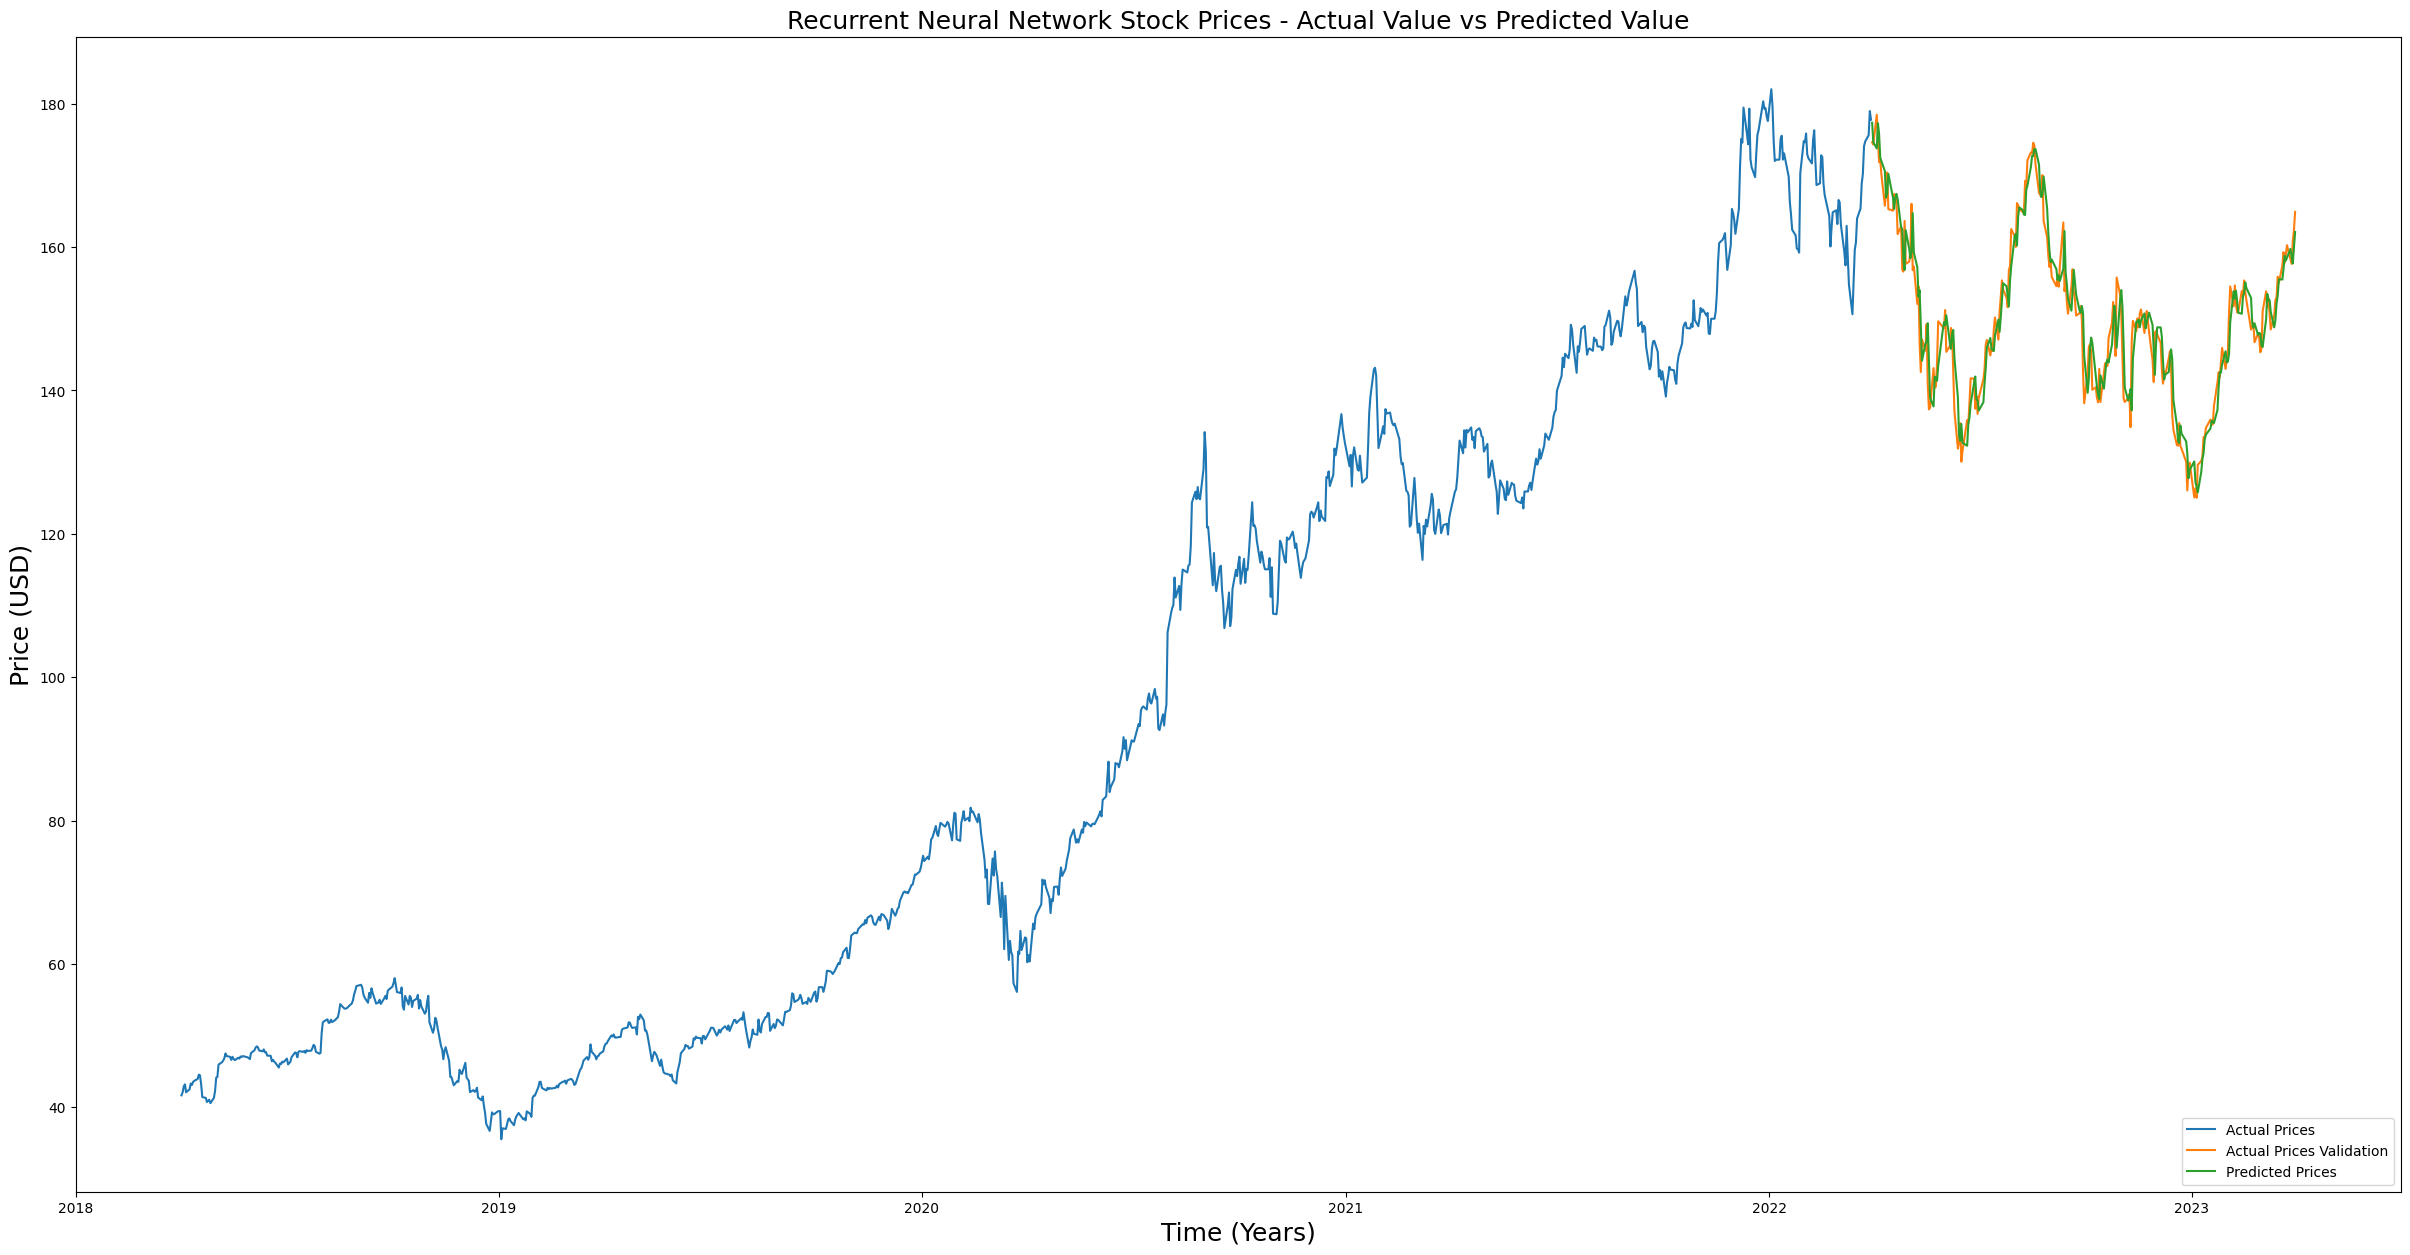

In [8]:
# Add predictions column to the data DataFrame
data['Predictions'] = np.nan
data.iloc[training_data_len:len(predictions)+training_data_len, -1] = predictions

# Split the data into training and validation sets
train = data[:training_data_len]
valid = data[training_data_len:]

# Visualize the data
plt.figure(figsize=(30,15))
plt.title('Recurrent Neural Network Stock Prices - Actual Value vs Predicted Value', fontsize=18)
plt.xlabel('Time (Years)', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Actual Prices', 'Actual Prices Validation', 'Predicted Prices'], loc='lower right')

# Save the figure as an image
plt.savefig('prediction_plot.png')

# GA Chart

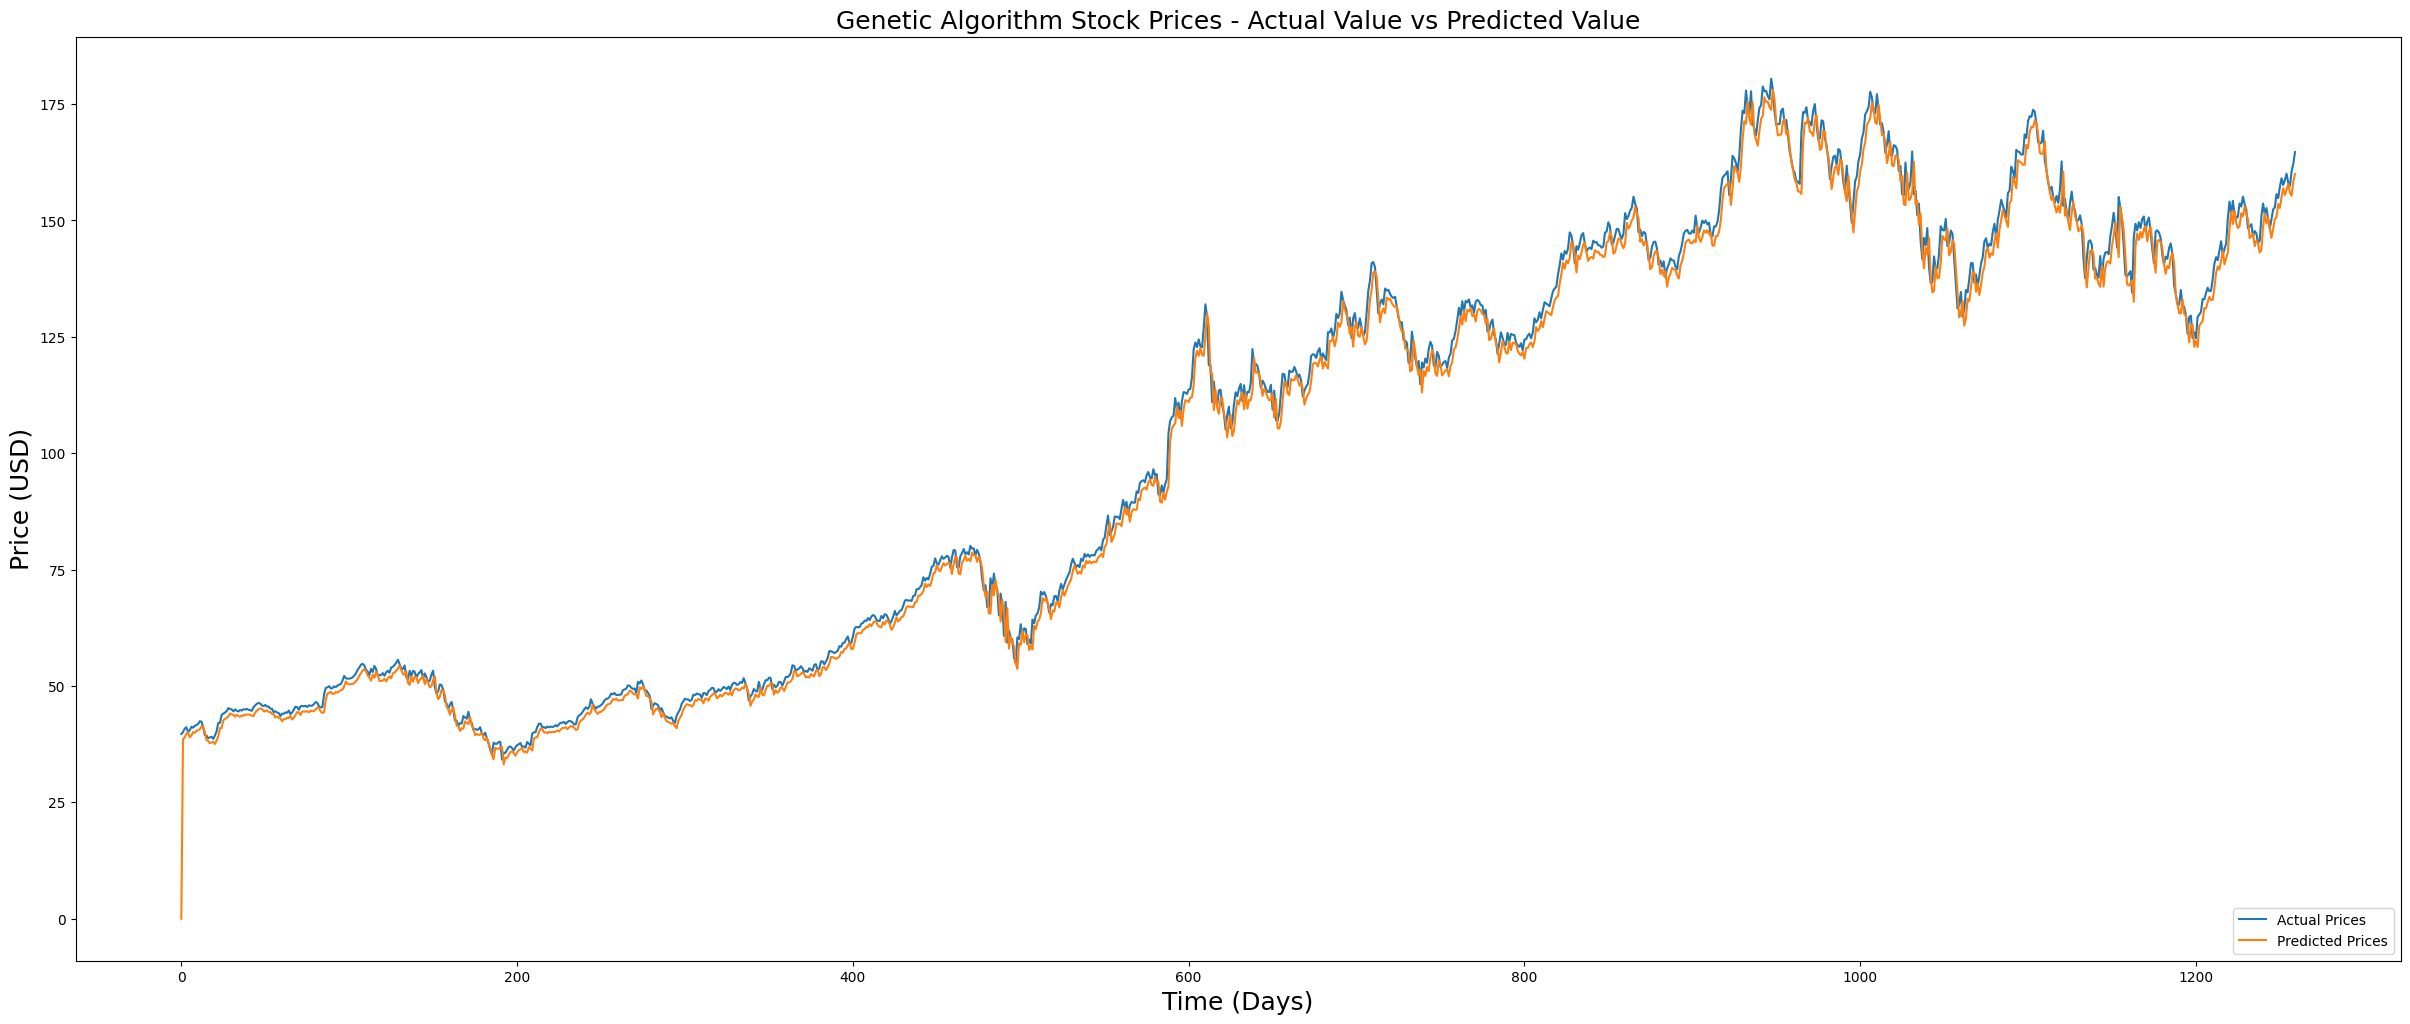

In [9]:
# Print the final chart
best_predicted_prices = predict_prices(best_chromosome, stock_dataGA)
plt.figure(figsize=(30,12))
plt.plot(stock_dataGA, label="Actual Prices")
plt.plot(best_predicted_prices, label="Predicted Prices")
plt.title("Genetic Algorithm Stock Prices - Actual Value vs Predicted Value", fontsize=18)
plt.xlabel("Time (Days)", fontsize=18)
plt.ylabel("Price (USD)", fontsize=18)
plt.legend(loc='lower right')
plt.show()

# Recommendation value

In [6]:
print("Recommendation:", recommendation.value)

Recommendation: Sell


# Predicted value

In [7]:
predictedValue = (future_price + next_day_prediction[0][0])/2
print(f"Predicted value: {predictedValue}")

Predicted value: 162.22191843731704
